## Runtime Environment

* python >= 3.7
* pytorch >= 1.0
* pandas
* nltk
* numpy
* sklearn
* pickle
* tqdm
* json

## Set Random seed

In [1]:
import torch
torch.manual_seed(42)

# Take a  view of dataset

In [2]:
import pandas as pd

dataset = pd.read_csv('../data/task2_trainset.csv', dtype=str)
dataset.head()

,Id,Title,Abstract,Authors,Categories,Created Date,Task 2
0,D00001,A Brain-Inspired Trust Management Model to Ass...,Rapid popularity of Internet of Things (IoT) a...,Mahmud/Kaiser/Rahman/Rahman/Shabut/Al-Mamun/Hu...,cs.CR/cs.AI/q-bio.NC,2018-01-11,THEORETICAL
1,D00002,On Efficient Computation of Shortest Dubins Pa...,"In this paper, we address the problem of compu...",Sadeghi/Smith,cs.SY/cs.RO/math.OC,2016-09-21,THEORETICAL
2,D00003,Data-driven Upsampling of Point Clouds,High quality upsampling of sparse 3D point clo...,Zhang/Jiang/Yang/Yamakawa/Shimada/Kara,cs.CV,2018-07-07,ENGINEERING
3,D00004,Accessibility or Usability of InteractSE? A He...,Internet is the main source of information now...,Aqle/Khowaja/Al-Thani,cs.HC,2018-08-29,EMPIRICAL
4,D00005,Spatio-Temporal Facial Expression Recognition ...,Automated Facial Expression Recognition (FER) ...,Hasani/Mahoor,cs.CV,2017-03-20,ENGINEERING


**Id**: 流水號  
**Title**: 論文標題  
**Abstract**: 論文摘要內容, 句子間以 **$$$** 分隔  
**Authors**: 論文作者  
**Categories**: 論文類別  
**Created date**: 論文上傳日期  
**Task 2**: 論文分類類別, 若句子有多個類別,以 **空格** 分隔 

# Data processing

## 刪除多於資訊 (Remove redundant information)  
我們在資料集中保留了許多額外資訊供大家使用，但是在這次的教學中我們並沒有用到全部資訊，因此先將多餘的部分先抽走。  
In dataset, we reserved lots of information. But in this tutorial, we don't need them, so we need to discard them.

In [3]:
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)

In [4]:
dataset.head()

,Id,Abstract,Task 2
0,D00001,Rapid popularity of Internet of Things (IoT) a...,THEORETICAL
1,D00002,"In this paper, we address the problem of compu...",THEORETICAL
2,D00003,High quality upsampling of sparse 3D point clo...,ENGINEERING
3,D00004,Internet is the main source of information now...,EMPIRICAL
4,D00005,Automated Facial Expression Recognition (FER) ...,ENGINEERING


## 資料切割  (Partition)
在訓練時，我們需要有個方法去檢驗訓練結果的好壞，因此需要將訓練資料切成training/validataion set。   
While training, we need some method to exam our model's performance, so we divide our training data into training/validataion set.

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

trainset, validset = train_test_split(dataset, test_size=0.1, random_state=42)

trainset.to_csv('trainset.csv', index=False)
validset.to_csv('validset.csv', index=False)

### For test data

In [6]:
dataset = pd.read_csv('../data/task2_public_testset.csv', dtype=str)
dataset.drop('Title',axis=1,inplace=True)
dataset.drop('Categories',axis=1,inplace=True)
dataset.drop('Created Date',axis=1, inplace=True)
dataset.drop('Authors',axis=1,inplace=True)
dataset.to_csv('testset.csv',index=False)

### 資料格式化 (Data formatting)  
有了字典後，接下來我們要把資料整理成一筆一筆，把input的句子轉成數字，把答案轉成onehot的形式。  
這裡，我們一樣使用`multiprocessing`來加入進行。  
After building dictionary, that's mapping our sentences into number array, and convert answers to onehot format.  

# BERT

In [7]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification

In [8]:
PRETRAINED_MODEL_NAME = 'bert-base-cased'

In [9]:
# class BERT(BertPreTrainedModel):

In [10]:
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

In [11]:
vocab = tokenizer.vocab
print("字典大小：", len(vocab))

字典大小： 28996


In [12]:
import random
random_tokens = random.sample(list(vocab), 10)
random_ids = [vocab[t] for t in random_tokens]

print("{0:20}{1:15}".format("token", "index"))
print("-" * 25)
for t, id in zip(random_tokens, random_ids):
    print("{0:15}{1:10}".format(t, id))

token               index          
-------------------------
Sultanate           26607
Union                1913
echoes              24390
deposited           14735
facto               14277
[unused5]               5
Spin                22878
value                2860
tentative           23113
councillors         16306


In [13]:
text = "[CLS] I love you. [SEP] Oh! [SEP] You are a [MASK] man."
tokens = tokenizer.tokenize(text)
ids = tokenizer.convert_tokens_to_ids(tokens)

print(text)
print(tokens[:20], '...')
print(ids[:20], '...')

[CLS] I love you. [SEP] Oh! [SEP] You are a [MASK] man.
['[CLS]', 'I', 'love', 'you', '.', '[SEP]', 'Oh', '!', '[SEP]', 'You', 'are', 'a', '[MASK]', 'man', '.'] ...
[101, 146, 1567, 1128, 119, 102, 2048, 106, 102, 1192, 1132, 170, 103, 1299, 119] ...


In [14]:
# 除了 tokens 以外我們還需要辨別句子的 segment ids
tokens_tensor = torch.tensor([ids])  # (1, seq_len)
segments_tensors = torch.zeros_like(tokens_tensor)  # (1, seq_len)
maskedLM_model = BertForMaskedLM.from_pretrained(PRETRAINED_MODEL_NAME)

# 使用 masked LM 估計 [MASK] 位置所代表的實際 token 
maskedLM_model.eval()
with torch.no_grad():
    outputs = maskedLM_model(tokens_tensor, segments_tensors)
    predictions = outputs[0]
    # (1, seq_len, num_hidden_units)
del maskedLM_model

# 將 [MASK] 位置的機率分佈取 top k 最有可能的 tokens 出來
masked_index = 12
k = 3
probs, indices = torch.topk(torch.softmax(predictions[0, masked_index], -1), k)
predicted_tokens = tokenizer.convert_ids_to_tokens(indices.tolist())

# 顯示 top k 可能的字。一般我們就是取 top 1 當作預測值
print("輸入 tokens ：", tokens[:20], '...')
print('-' * 50)
for i, (t, p) in enumerate(zip(predicted_tokens, probs), 1):
    tokens[masked_index] = t
    print("Top {} ({:2}%)：{}".format(i, int(p.item() * 100), tokens[:20]), '...')

輸入 tokens ： ['[CLS]', 'I', 'love', 'you', '.', '[SEP]', 'Oh', '!', '[SEP]', 'You', 'are', 'a', '[MASK]', 'man', '.'] ...
--------------------------------------------------
Top 1 (25%)：['[CLS]', 'I', 'love', 'you', '.', '[SEP]', 'Oh', '!', '[SEP]', 'You', 'are', 'a', 'wonderful', 'man', '.'] ...
Top 2 (23%)：['[CLS]', 'I', 'love', 'you', '.', '[SEP]', 'Oh', '!', '[SEP]', 'You', 'are', 'a', 'good', 'man', '.'] ...
Top 3 ( 9%)：['[CLS]', 'I', 'love', 'you', '.', '[SEP]', 'Oh', '!', '[SEP]', 'You', 'are', 'a', 'beautiful', 'man', '.'] ...


In [15]:
from tqdm import tqdm_notebook as tqdm
import torch
from multiprocessing import Pool

def label_to_onehot(labels):
    """ Convert label to onehot .
        Args:
            labels (string): sentence's labels.
        Return:
            outputs (onehot list): sentence's onehot label.
    """
    label_dict = {'THEORETICAL': 0, 'ENGINEERING':1, 'EMPIRICAL':2, 'OTHERS':3}
    onehot = [0,0,0,0]
    for l in labels.split():
        onehot[label_dict[l]] = 1
    return onehot
        
def sentence_to_indices(sent, idx, tokenizer):
    """ Convert sentence to its word indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    sentence = {}
    tokens = []
    if not idx:
        tokens = [tokenizer.convert_tokens_to_ids("[CLS]")]
    tokens = tokens + [tokenizer.convert_tokens_to_ids(word) for word in tokenizer.tokenize(sent)] + [tokenizer.convert_tokens_to_ids("[SEP]")]
    
    return tokens
    
def get_dataset(data_path, tokenizer, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """
    dataset = pd.read_csv(data_path, dtype=str)

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch, tokenizer))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, tokenizer):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], tokenizer))

    return processed

def preprocess_sample(data, tokenizer):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['tokens'] = [sentence_to_indices(sent, idx, tokenizer) 
                           for idx, sent in enumerate(data['Abstract'].split('$$$'))]
    
    processed['segments'] = []
    for idx, ids in enumerate(processed['tokens']):
        processed['segments'].append([idx] * len(ids))
    processed['tokens'] = sum(processed['tokens'], [])
    processed['segments'] = sum(processed['segments'], [])
    
    
    if 'Task 2' in data:
        processed['Label'] = label_to_onehot(data['Task 2'])
        
    return processed

In [16]:
print('[INFO] Start processing trainset...')
train = get_dataset('trainset.csv', tokenizer, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset('validset.csv', tokenizer, n_workers=4)
# print('[INFO] Start processing testset...')
# test = get_dataset('testset.csv', tokenizer, n_workers=4)

[INFO] Start processing trainset...




[INFO] Start processing validset...






## 資料封裝 (Data packing)

為了更方便的進行batch training，我們將會借助[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)。  
而要將資料放入dataloader，我們需要繼承[torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)，撰寫適合這份dataset的class。  
`collate_fn`用於batch data的後處理，在`dataloder`將選出的data放進list後會呼叫collate_fn，而我們會在此把sentence padding到同樣的長度，才能夠放入torch tensor (tensor必須為矩陣)。  

To easily training in batch, we'll use `dataloader`, which is a function built in Pytorch[torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)  
To use datalaoder, we need to packing our data into class `dataset` [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)  
`collate_fn` is used for data processing.

In [17]:
from torch.utils.data import Dataset
import torch

class BertDataset(Dataset):
    def __init__(self, data, max_len = 1000):
        self.data = data
        self.max_len = max_len
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
        
    def collate_fn(self, datas):
        # get max length in this batch
        max_len = max([min(len(data['tokens']), self.max_len) for data in datas])
        batch_tokens = []
        batch_segments = []
        batch_masks = []
        batch_label = []
        for data in datas:
            # padding abstract to make them in same length
            abstract_len = len(data['tokens'])
            if abstract_len > max_len:
                batch_tokens.append(data['tokens'][:max_len])
                batch_segments.append(data['segments'][:max_len])
                batch_masks.append([1] * max_len)
            else:
                batch_tokens.append(data['tokens'] + [0] * (max_len-abstract_len))
                batch_segments.append(data['segments'] + [0] * (max_len-abstract_len))
                batch_masks.append([1] * abstract_len  + [0] * (max_len-abstract_len))
            # gather labels
            if 'Label' in data:
                batch_label.append(data['Label'])
        return torch.LongTensor(batch_tokens), torch.LongTensor(batch_segments), torch.LongTensor(batch_masks), torch.FloatTensor(batch_label)

In [18]:
trainData = BertDataset(train)
validData = BertDataset(valid)
# testData = BertDataset(test)

# Train

指定使用的運算裝置  
Designate running device.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

定義一個算分公式, 讓我們在training能快速了解model的效能
Define score function, let us easily observe model performance while training.

In [20]:
class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.bool) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20)
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


In [21]:
import os
def _run_epoch(epoch, training):
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
    dataloader = DataLoader(dataset=dataset,
                            batch_size=2,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)
    
    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0.0
    f1_score = F1()
    for i, (tokens, segments, masks, labels) in trange:
        o_labels, batch_loss = _run_iter(tokens, segments, masks, labels)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()
        
        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), labels)
        
        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
    if training:
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})

        
def _run_iter(tokens, segments, masks, labels):
    tokens = tokens.to(device)
    segments = segments.to(device)
    masks = masks.to(device)
    labels = labels.to(device)
    o_labels = model(input_ids=tokens, 
                     token_type_ids=segments, 
                     attention_mask=masks, 
                     labels=labels)
    print(o_labels)
#     print(o_labels[0], labels.shape, labels[0])
#     l_loss = criteria(o_labels[0], labels)
    return o_labels, l_loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.'+str(epoch))
    with open('model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [22]:
from torch.utils.data import DataLoader
from tqdm import trange
import json
model = BertForSequenceClassification.from_pretrained(PRETRAINED_MODEL_NAME, num_labels = 4)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
# criteria = torch.nn.BCELoss()
model.to(device)
max_epoch = 1
history = {'train':[],'valid':[]}


In [24]:
for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, True)
    _run_epoch(epoch, False)
    save(epoch)

Epoch: 0


RuntimeError: CUDA error: device-side assert triggered

In [30]:
from torch.utils.data import DataLoader
from tqdm import trange
import json

dataloader = DataLoader(dataset=validData,
                            batch_size=64,
                            shuffle=False,
                            collate_fn=validData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
f1_score = F1()
with torch.no_grad():
    for i, data in trange:
        data = [t.to(device) for t in data]
        o_labels = model(*data[:3])
#         print(o_labels)
        o_labels = o_labels[0]>0.0
        prediction.append(o_labels.to('cpu'))
        f1_score.update(o_labels.cpu(), data[3].cpu())
print(f1_score.get_score())
    
prediction = torch.cat(prediction).detach().numpy().astype(int)



0.0


In [32]:
sum(prediction)

array([  1,   1,   0, 692])

In [26]:
print(f1_score.get_score())

0.0


# Model

資料處理完成後，接下來就是最重要的核心部分：`Model`。  
此次範例中我們以簡單的一層RNN + 一層Linear layer作為示範。  
而為了解決每次的句子長度不一的問題(`linear layer必須是fixed input size`)，因此我們把所有字的hidden_state做平均，讓這一個vector代表這句話。  

In this tutorial, we're going to implement a simple model, which contain one RNN layer and one fully connected layers (Linear layer). Of course you can make it "deep".  
To solve variant sentence length problem (`input size in linear layer must be fixed`), we can average all hidden_states, and become one vector. (Perfect!)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class simpleNet(nn.Module):
    def __init__(self, vocabulary_size):
        super(simpleNet, self).__init__()
        self.hidden_dim = 512
        self.sent_rnn = nn.GRU(vocabulary_size,
                                self.hidden_dim,
                                bidirectional=True,
                                batch_first=True)
        self.l1 = nn.Linear(self.hidden_dim, 4)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        b,s,w,e = x.shape
        x = x.view(b,s*w,e)
        x, __ = self.sent_rnn(x)
        x = self.dropout(x)
        x = x.view(b,s,w,-1)
        x = torch.max(x,dim=2)[0]
        x = x[:,:,:self.hidden_dim] + x[:,:,self.hidden_dim:]
        x = torch.max(x,dim=1)[0]
        x = torch.sigmoid(self.l1(F.relu(x)))
        return x

# Training

指定使用的運算裝置  
Designate running device.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

定義一個算分公式, 讓我們在training能快速了解model的效能  
Define score function, let us easily observe model performance while training.  

In [ ]:
class F1():
    def __init__(self):
        self.threshold = 0.5
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0

    def update(self, predicts, groundTruth):
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.bool) * predicts).data.item()

    def get_score(self):
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20)
        return 2 * (recall * precision) / (recall + precision + 1e-20)

    def print_score(self):
        score = self.get_score()
        return '{:.5f}'.format(score)


In [ ]:
import os
def _run_epoch(epoch, embedding, training):
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
    dataloader = DataLoader(dataset=dataset,
                            batch_size=20,
                            shuffle=shuffle,
                            collate_fn=dataset.collate_fn,
                            num_workers=4)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, y, sent_len) in trange:
        x = embedding(x)
        o_labels, batch_loss = _run_iter(x,y)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()

        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), y)

        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
    if training:
        history['train'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})
    else:
        history['valid'].append({'f1':f1_score.get_score(), 'loss':loss/ len(trange)})

def _run_iter(x,y):
    abstract = x.to(device)
    labels = y.to(device)
    o_labels = model(abstract)
    l_loss = criteria(o_labels, labels)
    return o_labels, l_loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.'+str(epoch))
    with open('model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

In [ ]:
from torch.utils.data import DataLoader
from tqdm import trange
import json
model = simpleNet(embedder.get_dim())
opt = torch.optim.Adam(model.parameters(), lr=2e-4)
criteria = torch.nn.BCELoss()
model.to(device)
max_epoch = 25
history = {'train':[],'valid':[]}


embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim())
embedding.weight = torch.nn.Parameter(embedder.vectors)


In [ ]:
embedding.weight.shape

In [ ]:
for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, embedding, True)
    _run_epoch(epoch, embedding, False)
    save(epoch)

# Plot

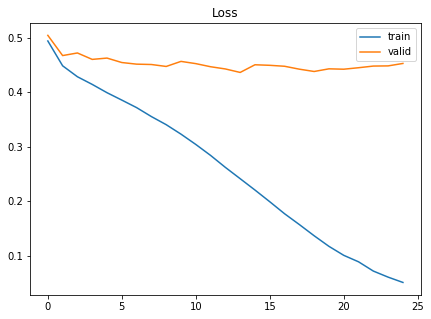

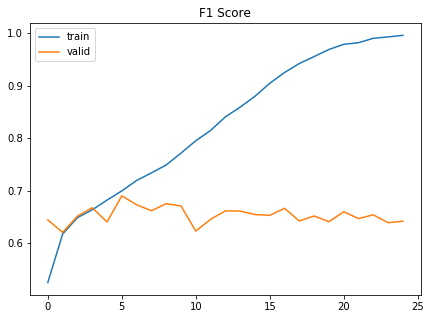

Best F1 score  [0.6901027582477015, 5]


In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

with open('model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1 Score')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

print('Best F1 score ', max([[l['f1'], idx] for idx, l in enumerate(history['valid'])]))

## Predict

In [34]:
model.load_state_dict(torch.load('model/model.pkl.{}'.format(5)))
model.train(False)
_run_epoch(1, embedding, False)
dataloader = DataLoader(dataset=testData,
                            batch_size=64,
                            shuffle=False,
                            collate_fn=testData.collate_fn,
                            num_workers=4)
trange = tqdm(enumerate(dataloader), total=len(dataloader), desc='Predict')
prediction = []
for i, (x,y,_l) in trange:
    x = embedding(x)
    o_labels = model(x.to(device))
    o_labels = o_labels>0.5
    prediction.append(o_labels.to('cpu'))

prediction = torch.cat(prediction).detach().numpy().astype(int)

In [35]:
def SubmitGenerator(prediction, sampleFile, public=True, filename='prediction.csv'):
    """
    Args:
        prediction (numpy array)
        sampleFile (str)
        public (boolean)
        filename (str)
    """
    sample = pd.read_csv(sampleFile)
    submit = {}
    submit['order_id'] = list(sample.order_id.values)
    redundant = len(sample) - prediction.shape[0]
    if public:
        submit['THEORETICAL'] = list(prediction[:,0]) + [0]*redundant
        submit['ENGINEERING'] = list(prediction[:,1]) + [0]*redundant
        submit['EMPIRICAL'] = list(prediction[:,2]) + [0]*redundant
        submit['OTHERS'] = list(prediction[:,3]) + [0]*redundant
    else:
        submit['THEORETICAL'] = [0]*redundant + list(prediction[:,0])
        submit['ENGINEERING'] = [0]*redundant + list(prediction[:,1])
        submit['EMPIRICAL'] = [0]*redundant + list(prediction[:,2])
        submit['OTHERS'] = [0]*redundant + list(prediction[:,3])
    df = pd.DataFrame.from_dict(submit) 
    df.to_csv(filename,index=False)

In [41]:
SubmitGenerator(prediction, 
                '../data/task2_sample_submission.csv',
                True, 
                '../score/task2/task2_submission.csv')